In [1]:
from truthnet import truthnet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import tikzplotlib as tpl
from datetime import datetime

from sklearn.ensemble import (
    ExtraTreesClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    auc,
    mean_squared_error,
    precision_recall_curve,
    r2_score,
    roc_curve,
)

In [2]:
Tr = truthnet()
features, samples = Tr.load_data(datapath="data/PTSD_cognet_test_processed.csv")
Tr.fit(modelpath="tmp_Qnet.joblib")

In [3]:
Tr_pos = truthnet()
# feat_pos, samp_pos = pos_samps.columns, pos_samps.to_numpy(dtype='<U21', na_value='')
feat_pos, samp_pos = Tr_pos.load_data(
    datapath="data/PTSD_cognet_test_processed_pos_only.csv"
)
Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")

We order questions based on increasing entropy: questions with the least entropy have the most potential for dissonant/surprising responses. (This could also be done dynamically: after each response, recompute the distributions and choose the remaining one with minimal entropy.)

In [2]:
from scipy.stats import entropy
import random
from quasinet.utils import sample_from_dict


def _diss_linear(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(1 - Ds[i][s[i]] / np.max(list(Ds[i].values())))
            else:
                diss.append(1)

    return np.array(diss)


def _diss_log(s, qnet):
    diss = list()
    Ds = qnet.predict_distributions(s)

    for i in range(len(s)):
        if s[i] != "":
            if s[i] in Ds[i].keys():
                diss.append(-np.log(Ds[i][s[i]]))
            else:
                diss.append(np.inf)

    return np.array(diss)


def _compare_dissonance(
    samples, qnet, qnet_pos, order=None, diss_fcn=_diss_linear, plot=True
):
    samples_df = pd.DataFrame(samples)
    sample_values = pd.Series({col: samples_df[col].unique() for col in samples_df})

    if order is None:
        order = range(len(samples[0]))

    mean_diss_random = list()
    mean_diss_qsampled = list()
    mean_diss_m2 = list()
    mean_diss_m3 = list()

    new_samp_r = np.full_like(samples[0], fill_value="")
    new_samp_q = np.full_like(samples[0], fill_value="")
    new_samp_m2 = np.full_like(samples[0], fill_value="")
    new_samp_m3 = np.full_like(samples[0], fill_value="")

    for i in order:
        # generate answers randomly
        new_samp_r[i] = random.choice(sample_values[i])
        mean_diss_random.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_r, qnet)))
        )

        # baseline/comparison answers (generated from full model)
        prob_dict = qnet.predict_distribution(new_samp_q, i)
        new_samp_q[i] = sample_from_dict(prob_dict)
        mean_diss_qsampled.append(
            np.mean(np.ma.masked_invalid(diss_fcn(new_samp_q, qnet)))
        )

        # generate answers from positive qnet distributions
        prob_dict_pos = qnet_pos.predict_distribution(new_samp_m2, i)
        new_samp_m2[i] = sample_from_dict(prob_dict_pos)
        mean_diss_m2.append(np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m2, qnet))))

        new_samp_m3[i] = random.choices(
            sample_values[i], weights=sample_values[i].astype(int) ** 2
        )[0]
        mean_diss_m3.append(np.mean(np.ma.masked_invalid(diss_fcn(new_samp_m3, qnet))))

    mean_diss_qsampled = np.array(mean_diss_qsampled)
    mean_diss_random = np.array(mean_diss_random)
    mean_diss_m2 = np.array(mean_diss_m2)
    mean_diss_m3 = np.array(mean_diss_m3)

    mean_df = pd.DataFrame(
        {
            "random_diss": mean_diss_random,
            "qsampled_diss": mean_diss_qsampled,
            "m2_diss": mean_diss_m2,
            "m3_diss": mean_diss_m3,
        }
    )

    if plot is True:
        sns.relplot(
            data=pd.melt(
                mean_df.reset_index(),
                id_vars="index",
            ),
            x="index",
            y="value",
            hue="variable",
        )

    return pd.concat(
        [
            mean_df,
            pd.DataFrame(
                {
                    "random_resp": new_samp_r,
                    "qsampled_resp": new_samp_q,
                    "m2_resp": new_samp_m2,
                    "m3_resp": new_samp_m3,
                }
            ),
        ],
        axis=1,
    )

In [5]:
Ds = Tr.cognet_obj.qnet.predict_distributions(np.full_like(samples[0], fill_value=""))
entrpy = list()
for i in range(len(Ds)):
    entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))

entropy_order = pd.Series(entrpy).sort_values().index

## Linear dissonance

### Entropy ordering

In [6]:
mean_dfs = [
    _compare_dissonance(
        samples,
        Tr.cognet_obj.qnet,
        Tr_pos.cognet_obj.qnet,
        order=entropy_order,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

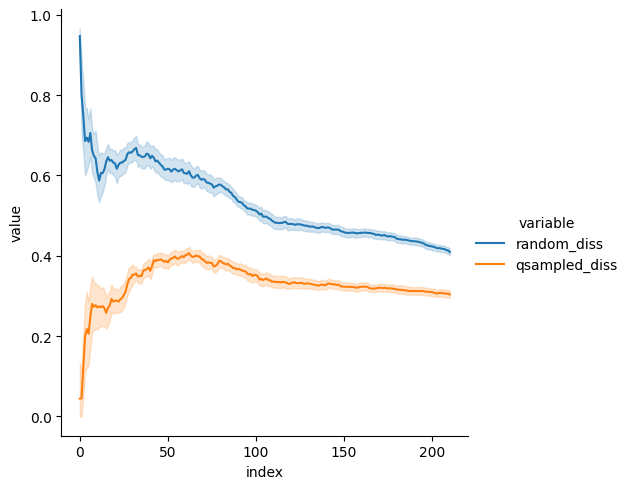

In [7]:
sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[["random_diss", "qsampled_diss"]].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

### Random ordering

In [8]:
random_order = list(range(len(samples[0])))
random.shuffle(random_order)

mean_dfs = [
    _compare_dissonance(
        samples,
        Tr.cognet_obj.qnet,
        Tr_pos.cognet_obj.qnet,
        order=random_order,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

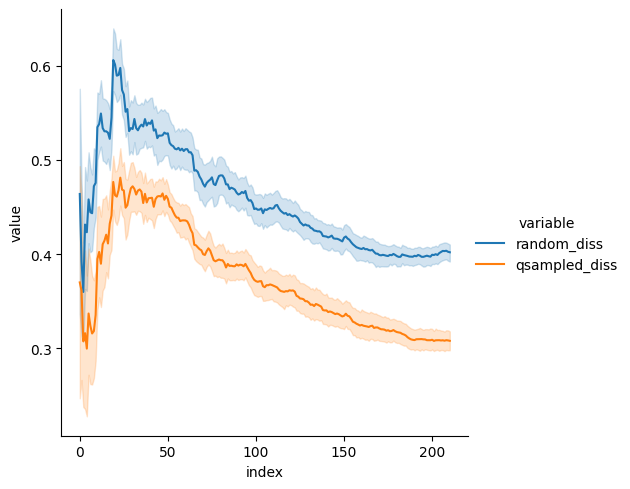

In [9]:
sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[["random_diss", "qsampled_diss"]].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

## Log. dissonance

In [10]:
mean_dfs = [
    _compare_dissonance(
        samples,
        Tr.cognet_obj.qnet,
        Tr_pos.cognet_obj.qnet,
        order=entropy_order,
        diss_fcn=_diss_log,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

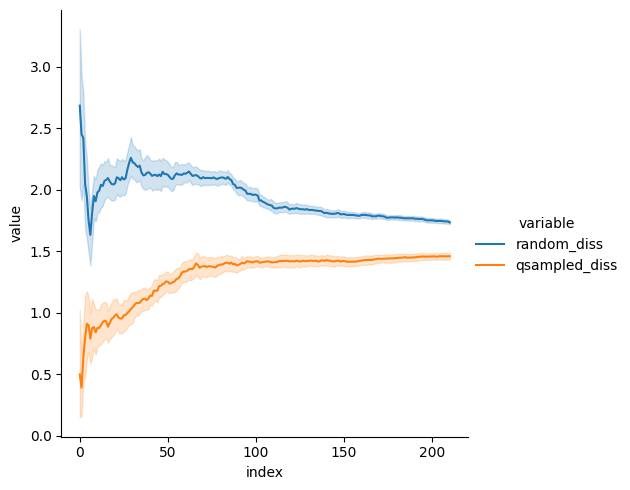

In [11]:
sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[["random_diss", "qsampled_diss"]].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

## Adversarial responses

In [ ]:
mean_dfs = [
    _compare_dissonance(
        samples,
        Tr.cognet_obj.qnet,
        Tr_pos.cognet_obj.qnet,
        diss_fcn=_diss_log,
        plot=False,
    )
    for i in tqdm(range(20))
]

  0%|          | 0/20 [00:00<?, ?it/s]

NameError: name '_compare_dissonance' is not defined

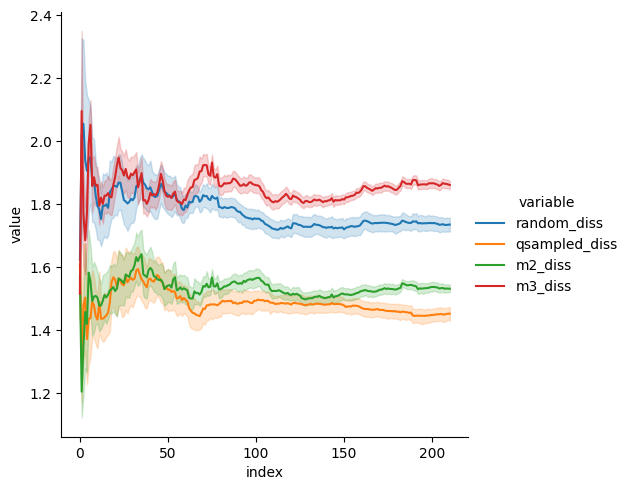

In [13]:
g = sns.relplot(
    data=pd.melt(
        pd.concat(mean_dfs)[
            ["random_diss", "qsampled_diss", "m2_diss", "m3_diss"]
        ].reset_index(),
        id_vars="index",
    ),
    x="index",
    y="value",
    hue="variable",
    kind="line",
)

In [14]:
def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

In [15]:
tikzplotlib_fix_ncols(g.figure)

In [16]:
print(
    tpl.get_tikz_code(
        g.figure,
        standalone=False,
    )
)

% This file was created with tikzplotlib v0.10.1.
\begin{tikzpicture}

\definecolor{crimson2143940}{RGB}{214,39,40}
\definecolor{darkgray176}{RGB}{176,176,176}
\definecolor{darkorange25512714}{RGB}{255,127,14}
\definecolor{forestgreen4416044}{RGB}{44,160,44}
\definecolor{steelblue31119180}{RGB}{31,119,180}

\begin{axis}[
tick align=outside,
tick pos=left,
x grid style={darkgray176},
xlabel={index},
xmin=-10.5, xmax=220.5,
xtick style={color=black},
y grid style={darkgray176},
ylabel={value},
ymin=1.06216119160962, ymax=2.41216964553957,
ytick style={color=black}
]
\path [draw=steelblue31119180, fill=steelblue31119180, opacity=0.2]
(axis cs:0,1.69457518568338)
--(axis cs:0,1.54261523577751)
--(axis cs:1,1.70772735425227)
--(axis cs:2,1.77665606746733)
--(axis cs:3,1.70933634920906)
--(axis cs:4,1.69157086834151)
--(axis cs:5,1.77184908581238)
--(axis cs:6,1.80443200593842)
--(axis cs:7,1.74409150134051)
--(axis cs:8,1.74265054301535)
--(axis cs:9,1.72056418470889)
--(axis cs:10,1.687344

## Classification


Get dissonance values for specified number of runs, process for classifier training

### single run

In [12]:
def _get_quest_diss(diss_df, questions):
    qs_df = pd.DataFrame(
        [
            diss_df.groupby("run").nth(i)["qsampled_diss"].values
            for i in range(questions)
        ]
    ).T.assign(group="qsampled")
    m2_df = pd.DataFrame(
        [diss_df.groupby("run").nth(i)["m2_diss"].values for i in range(questions)]
    ).T.assign(group="m2")

    return pd.concat([qs_df, m2_df])

In [55]:
df_tra = pd.concat(
    [
        _compare_dissonance(
            samples,
            Tr.cognet_obj.qnet,
            Tr_pos.cognet_obj.qnet,
            plot=False,
        ).assign(run=i)
        for i in tqdm(range(50))
    ]
)

df_tst = pd.concat(
    [
        _compare_dissonance(
            samples,
            Tr.cognet_obj.qnet,
            Tr_pos.cognet_obj.qnet,
            plot=False,
        ).assign(run=i)
        for i in tqdm(range(5))
    ]
)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [56]:
df_tra

,random_diss,qsampled_diss,m2_diss,m3_diss,random_resp,qsampled_resp,m2_resp,m3_resp,run
0,0.227848,0.253165,0.227848,0.000000,1,2,1,5,0
1,0.180591,0.126582,0.113924,0.473333,1,2,2,4,0
2,0.750893,0.129353,0.376961,0.381920,4,2,2,5,0
3,0.586580,0.209302,0.186567,0.342576,2,1,3,4,0
4,0.645735,0.167442,0.337489,0.435663,4,1,2,4,0
...,...,...,...,...,...,...,...,...,...
206,0.371085,0.295311,0.322500,0.452746,4,2,3,3,49
207,0.371698,0.298270,0.322052,0.453819,4,1,4,5,49
208,0.374396,0.299735,0.322164,0.452657,1,2,3,5,49
209,0.373448,0.299699,0.320502,0.452705,5,3,2,5,49


In [57]:
fig, ax = plt.subplots()

aucs = list()

quest_iter = range(1, 211, 5)

for i in tqdm(quest_iter):
    tra = _get_quest_diss(df_tra, i)
    X_train = tra.iloc[:, :i]
    y_train = tra.iloc[:, -1]

    tst = _get_quest_diss(df_tst, i)
    X_test = tst.iloc[:, :i]
    y_test = tst.iloc[:, -1]
    forest = RandomForestClassifier(n_estimators=100, oob_score=True)
    forest.fit(X_train, y_train)

    r = RocCurveDisplay.from_estimator(
        forest, X_test, y_test, pos_label="m2", ax=ax, name=tra.columns[i - 1]
    )
    aucs.append(r.roc_auc)
    plt.close()

# ax.legend(bbox_to_anchor=(1.1, 1.05))

  0%|          | 0/42 [00:00<?, ?it/s]

<Axes: xlabel='questions asked'>

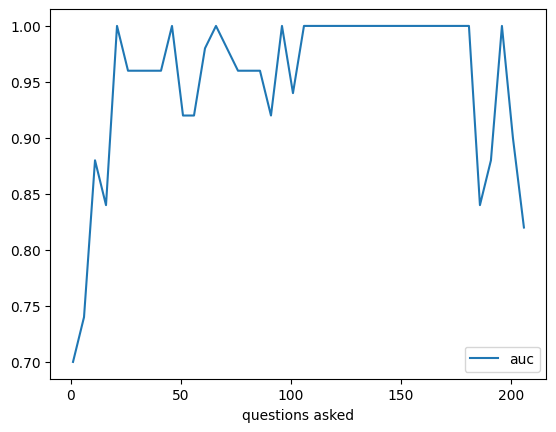

In [58]:
auc_df = pd.DataFrame({"questions asked": quest_iter, "auc": aucs})

auc_df.plot(x="questions asked", y="auc")

In [54]:
aucs = list()
rocs = list()
z_aucs = list()
for i in tqdm(quest_iter):
    tra = _get_quest_diss(df_tra, i)
    X_train = tra.iloc[:, :i]
    y_train = tra.iloc[:, -1]

    tst = _get_quest_diss(df_tst, i)
    X_test = tst.iloc[:, :i]
    y_test = tst.iloc[:, -1]
    clf = ExtraTreesClassifier(oob_score=True, bootstrap=True)
    clf.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(
        y_test, clf.predict_proba(X_test)[:, 1], pos_label="m2"
    )
    roc_df = pd.DataFrame({"fpr": fpr, "tpr": tpr, "threshold": thresholds})
    zt = zedstat.processRoc(
        df=roc_df,
        order=3,
        total_samples=20,
        positive_samples=10,
        alpha=0.01,
        prevalence=0.25,
    )

    # compute smoothened roc and other performance measures
    zt.smooth(STEP=0.001)
    zt.allmeasures(interpolate=False)
    zt.usample(precision=3)
    zt.getBounds()

    r = RocCurveDisplay.from_estimator(
        clf, X_test, y_test, pos_label="m2", ax=ax, name=tra.columns[i - 1]
    )
    aucs.append(r.roc_auc)
    z_aucs.append(zt.auc()[0])
    rocs.append(roc_df)
    plt.close()

  0%|          | 0/42 [00:00<?, ?it/s]

AttributeError: 'processRoc' object has no attribute 'delta_'

In [36]:
from zedstat import zedstat

In [49]:
aucs

[0.5,
 0.46,
 0.39999999999999997,
 0.44,
 0.4800000000000001,
 0.64,
 0.88,
 0.88,
 0.92,
 1.0,
 0.9800000000000001,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

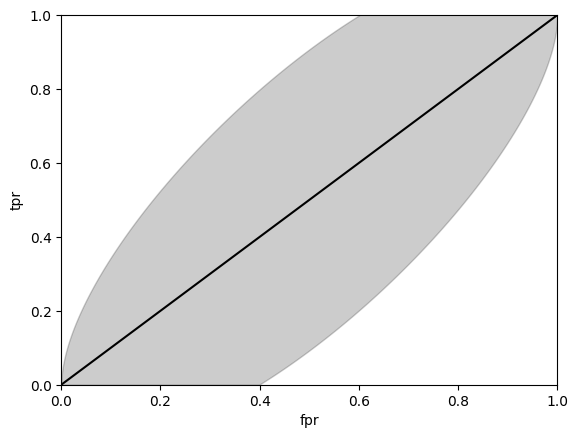

In [45]:
zt = zedstat.processRoc(
    df=rocs[0],
    order=3,
    total_samples=20,
    positive_samples=10,
    alpha=0.01,
    prevalence=0.25,
)

# compute smoothened roc and other performance measures
zt.smooth(STEP=0.001)
zt.allmeasures(interpolate=False)
zt.usample(precision=3)
zt.getBounds()

ax = plt.gca()
ax = zt.get().tpr.plot(ax=ax, color="k")
plt.fill_between(
    x=zt.get().index, y1=zt.df_lim["U"].tpr, y2=zt.df_lim["L"].tpr, color="k", alpha=0.2
)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel("tpr")

In [50]:
zt.auc()[0]

0.5

In [40]:
# compute smoothened roc and other performance measures
zt.smooth(STEP=0.001)
zt.allmeasures(interpolate=False)
zt.usample(precision=3)
zt.getBounds()

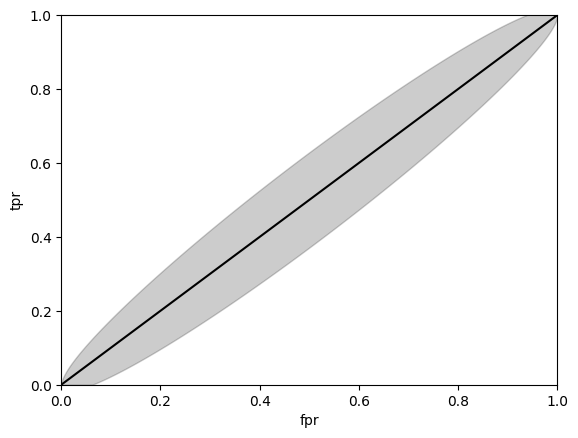

In [41]:
ax = plt.gca()
ax = zt.get().tpr.plot(ax=ax, color="k")
plt.fill_between(
    x=zt.get().index, y1=zt.df_lim["U"].tpr, y2=zt.df_lim["L"].tpr, color="k", alpha=0.2
)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_ylabel("tpr")

In [35]:
rocs[41]

,fpr,tpr,threshold
0,0.0,0.0,1.99
1,0.2,0.0,0.99
2,0.4,0.0,0.93
3,0.8,0.0,0.89
4,1.0,0.0,0.76
5,1.0,1.0,0.01


In [24]:
r.tpr

array([0. , 0.2, 1. , 1. ])

<Axes: xlabel='questions asked'>

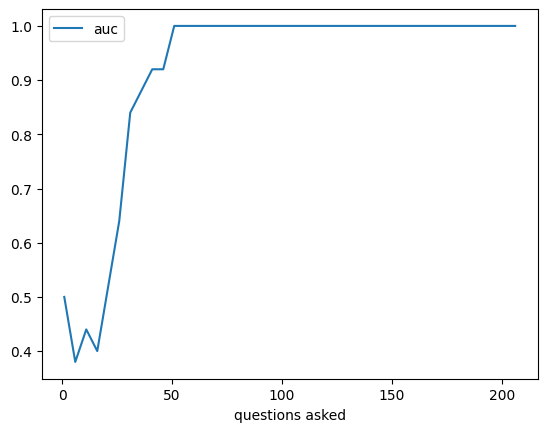

In [18]:
auc_dfx = pd.DataFrame({"questions asked": quest_iter, "auc": aucs})

auc_dfx.plot(x="questions asked", y="auc")

In [20]:
pd.merge(auc_dfx, auc_df, how="left", on="questions asked")

,questions asked,auc_x,auc_y
0,1,0.50,0.50
1,6,0.38,0.38
2,11,0.44,0.50
3,16,0.40,0.44
4,21,0.52,0.54
5,26,0.64,0.72
6,31,0.84,0.84
7,36,0.88,0.84
8,41,0.92,0.98
9,46,0.92,1.00


### batch run

In [3]:
def _get_quest_diss(diss_df, questions):
    qs_df = pd.DataFrame(
        [
            diss_df.groupby("run").nth(i)["qsampled_diss"].values
            for i in range(questions)
        ]
    ).T.assign(group="qsampled")
    m2_df = pd.DataFrame(
        [diss_df.groupby("run").nth(i)["m2_diss"].values for i in range(questions)]
    ).T.assign(group="m2")

    return pd.concat([qs_df, m2_df])

In [6]:
def _get_auc_df(n_train=20, n_test=5):
    Tr = truthnet()
    features, samples = Tr.load_data(datapath="data/PTSD_cognet_test_processed.csv")
    Tr.fit(modelpath="tmp_Qnet.joblib")
    Tr_pos = truthnet()
    # feat_pos, samp_pos = pos_samps.columns, pos_samps.to_numpy(dtype='<U21', na_value='')
    feat_pos, samp_pos = Tr_pos.load_data(
        datapath="data/PTSD_cognet_test_processed_pos_only.csv"
    )
    Tr_pos.fit(modelpath="tmp_Qnet_pos.joblib")

    Ds = Tr.cognet_obj.qnet.predict_distributions(
        np.full_like(samples[0], fill_value="")
    )
    entrpy = list()
    for i in range(len(Ds)):
        entrpy.append(entropy(np.fromiter(Ds[i].values(), dtype=float)))

    entropy_order = pd.Series(entrpy).sort_values().index

    fig, ax = plt.subplots()

    df_tra = pd.concat(
        [
            _compare_dissonance(
                samples,
                Tr.cognet_obj.qnet,
                Tr_pos.cognet_obj.qnet,
                order=entropy_order,
                plot=False,
            ).assign(run=i)
            for i in tqdm(range(n_train))
        ]
    )

    df_tst = pd.concat(
        [
            _compare_dissonance(
                samples,
                Tr.cognet_obj.qnet,
                Tr_pos.cognet_obj.qnet,
                order=entropy_order,
                plot=False,
            ).assign(run=i)
            for i in tqdm(range(n_test))
        ]
    )

    time = str(datetime.now())
    df_tra.to_csv("diss_training_" + time + ".csv", index=False)
    df_tst.to_csv("diss_test_" + time + ".csv", index=False)

    aucs = list()

    quest_iter = range(1, 211, 5)

    for i in quest_iter:
        tra = _get_quest_diss(df_tra, i)
        X_train = tra.iloc[:, :i]
        y_train = tra.iloc[:, -1]

        tst = _get_quest_diss(df_tst, i)
        X_test = tst.iloc[:, :i]
        y_test = tst.iloc[:, -1]
        forest = RandomForestClassifier(n_estimators=100, oob_score=True)
        forest.fit(X_train, y_train)

        r = RocCurveDisplay.from_estimator(
            forest, X_test, y_test, pos_label="m2", ax=ax, name=tra.columns[i - 1]
        )
        aucs.append(r.roc_auc)
        plt.close()

    auc_df = pd.DataFrame({"questions asked": quest_iter, "auc": aucs})
    return auc_df

In [ ]:
for i in tqdm(range(10)):
    _get_auc_df(n_train=100, n_test=15).to_csv("auc_df_" + str(i) + ".csv", index=False)

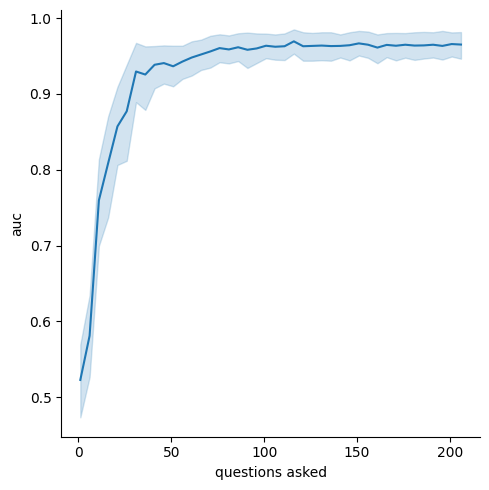

In [5]:
g = sns.relplot(
    data=pd.read_csv("auc_df_x10_train_samps_100.csv"),
    x="questions asked",
    y="auc",
    kind="line",
)

In [ ]:
print(tpl.get_tikz_code(g.figure, standalone=False))

In [6]:
def _sns_plot_to_df(ax, line_idx=0):
    # get mean
    mean_p_df = pd.DataFrame(
        data={0: ax.lines[line_idx].get_xdata(), 1: ax.lines[0].get_ydata()}
    )

    # get upper/lower conf. bounds
    p = ax.collections[0].get_paths()
    p_df = pd.DataFrame(p[0].vertices).sort_values(by=[0, 1]).drop_duplicates()
    p_df["lim"] = [
        x
        for y in zip(np.tile("lower", len(mean_p_df)), np.tile("upper", len(mean_p_df)))
        for x in y
    ]

    # merge
    p_df_p = p_df.pivot(index=0, columns="lim").reset_index()
    p_df_p.columns = p_df_p.columns.to_flat_index()
    p_df_p = p_df_p.set_axis(["x", "ci_lower", "ci_upper"], axis="columns")
    df = pd.merge(p_df_p, mean_p_df, how="inner", left_on="x", right_on=0)

    df = df.rename(columns={1: "mean"}).drop(0, axis="columns")
    return df[["x", "mean", "ci_lower", "ci_upper"]]

In [7]:
_sns_plot_to_df(g.figure.gca()).to_csv(
    "auc_df_x10_train_samps_100_ci_vals.csv", index=False
)

## Def. of dissonance

Letting $\text{ans}$ be the set of answers and a response $x \in \text{ans}$, the (linear) dissonance of $x$ is defined as $$\operatorname{Dissonance}(x)= 1 - \dfrac{\operatorname{Pr}(x)}{\operatorname{max}_{a \in \text{ans}}\operatorname{Pr}(a)}$$ 

Thus the dissonance is supported on $[0,1]$, is minimized at the highest probability response, and is maximal ($=1$) at probability $0$ responses. We also see that it scales linearly with probability of the response.

## Results

- distinguish between random/non-random responses
- reconstruction of responses
- include diagnostic phenotypes